In [29]:

import sys
import ROOT as R
import time
import numpy as np
import xgboost as xgb
import pandas as pd
import os
import matplotlib.pyplot as plt
import xgboost as xgb

In [30]:
muon_df =pd.read_feather("mumfeather.feather") #read in muon and electron feather to pandas dataframe
print(f"Number of muon events in data set is {len(muon_df)}")

elec_df = pd.read_feather("electronfeather25k.feather")
print(f"Number of electron envents in data set is {len(elec_df)}")


Number of muon events in data set is 93498
Number of electron envents in data set is 15160


In [3]:
#add column [pdg] for particle identification 
muon_df['pdg_id'] = pd.Series([13 for x in range(len(muon_df.index))])
elec_df['pdg_id'] = pd.Series([11 for x in range(len(muon_df.index))])
#verify id column with constant value

#split dfs into two for training and validation. 60% training, 40% validation for now
muon_short = muon_df.iloc[0:50000]
elec_short = elec_df.iloc[0:]
muon_df_training = muon_df.iloc[0:30000]
muon_df_validation = muon_df.iloc[30000:50000]
elec_df_training = elec_df.iloc[0:10000]
elec_df_validation = elec_df.iloc[10000:]


print(f"Number of muon events for training: {len(muon_df_training)}")
print(f"Number of muon events for validation: {len(muon_df_validation)}")
print(f"Number of electron events for training: {len(elec_df_training)}")
print(f"Number of electron events for validation: {len(elec_df_validation)}")

#combine training dataframes:
combined_df = pd.concat([muon_short, elec_short], ignore_index=True)
#permute the combined dataframe to randomly mix the indices
#ran_loc = np.random.permutation(len(combined))  
shuffled_df= combined_df.sample(frac = 1)
#make sure shuffled df looks correct
print(f"Number of shuffled events: {len(shuffled_df)}")
shuffled_df.head()
shuffled_df.tail()

#split the shuffled df
shuffled_training_df = shuffled_df.iloc[0:50000]
shuffled_validation_df = shuffled_df.iloc[50000:]

print(f"Number of shuffled events for training: {len(shuffled_training_df)}")
print(f"Number of shuffled events for validation: {len(shuffled_validation_df)}")


Number of muon events for training: 30000
Number of muon events for validation: 20000
Number of electron events for training: 10000
Number of electron events for validation: 5160
Number of shuffled events: 65160
Number of shuffled events for training: 50000
Number of shuffled events for validation: 15160


In [4]:
for col in shuffled_training_df.columns:
    print(col)
print('Fraction e/mu: {}'.format(len(shuffled_training_df[shuffled_training_df.pdg_id == 11])/(float)(len(shuffled_training_df[shuffled_training_df.pdg_id == 13]) + len(shuffled_training_df[shuffled_training_df.pdg_id == 11]))))    

energy
energy_cor
x
y
x_cor
y_cor
nhits
seed_e
seed_ix
seed_iy
true_e
score_e
score_x
score_y
pdg_id
Fraction e/mu: 0.23314


In [5]:
#drop columns related to truth quantities
only_ecal_tr_df = shuffled_training_df.drop(columns=['true_e','score_e','score_x','score_y'])
only_ecal_val_df = shuffled_validation_df.drop(columns=['true_e','score_e','score_x','score_y'])

feature_names = only_ecal_tr_df.columns[0:-1] #drop the pdg_id, as its not a dependent variable
print(feature_names)



Index(['energy', 'energy_cor', 'x', 'y', 'x_cor', 'y_cor', 'nhits', 'seed_e',
       'seed_ix', 'seed_iy'],
      dtype='object')


In [28]:
only_ecal_tr_df['pdg_id']=only_ecal_tr_df['pdg_id'].astype('category')
only_ecal_val_df['pdg_id']=only_ecal_val_df['pdg_id'].astype('category')
only_ecal_val_df.dtypes
only_ecal_tr_df.shape
#only_ecal_val_df.shape

(50000, 11)

In [7]:
#trying to convert the 'object' datatype in these dfs into floats to use for training program
#FIXED BY FEATHER FORMAT!
#only_ecal_tr_df['ecal_cluster_uncor_energy'] = only_ecal_tr_df['ecal_cluster_uncor_energy'].astype(float)
#only_ecal_tr_df['ecal_cluster_x']=pd.to_numeric(only_ecal_tr_df['ecal_cluster_x'])
#only_ecal_tr_df['ecal_cluster_uncor_energy'] = only_ecal_tr_df['ecal_cluster_uncor_energy'].str.replace(']', '')
#only_ecal_tr_df['ecal_cluster_uncor_energy'] = only_ecal_tr_df['ecal_cluster_uncor_energy'].str.replace('\D', '', regex=True)
#only_ecal_tr_df.tail()
#only_ecal_tr_df.astype('float').dtypes
#only_ecal_tr_df.head()

In [8]:
train = xgb.DMatrix(data=only_ecal_tr_df[feature_names],label=only_ecal_tr_df.pdg_id.cat.codes, #what is .cat.codes??
                    missing=-999.0,feature_names=feature_names)
test = xgb.DMatrix(data=only_ecal_val_df[feature_names],label=only_ecal_val_df.pdg_id.cat.codes,
                   missing=-999.0,feature_names=feature_names)

In [9]:
print('Number of training samples: {}'.format(train.num_row()))
print('Number of testing samples: {}'.format(test.num_row()))

print('\nNumber of muon events in training set: {}'.format(len(np.where(train.get_label())[0])))

Number of training samples: 50000
Number of testing samples: 15160

Number of muon events in training set: 38343


In [10]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10 # maximum depth of a tree
param['subsample']        = .8 # fraction of events to train tree on
param['colsample_bytree'] = .8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

In [11]:
booster = xgb.train(param,train,num_boost_round=num_trees)

In [12]:
print(booster.eval(test))

[0]	eval-rmse:0.15858579722169977	eval-rmse:0.15858579722169977	eval-rmse:0.15858579722169977


In [13]:
predictions = booster.predict(test)

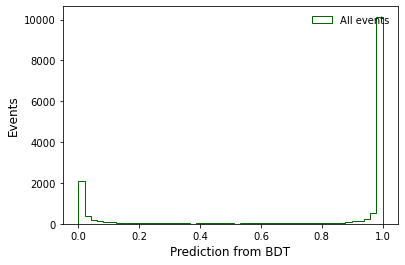

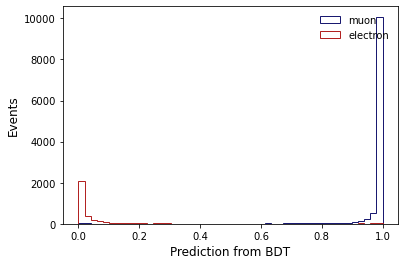

In [14]:
# plot all predictions (both signal and background)
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='muon');
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='electron');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

/tmp/ipykernel_1486/2898212770.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(nsignal/len(only_ecal_val_df[only_ecal_val_df.pdg_id == 13]),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


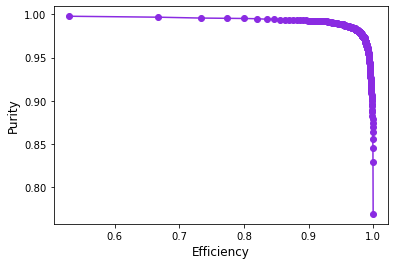

In [15]:
# choose score cuts:
cuts = np.linspace(0,1,500);
nsignal = np.zeros(len(cuts));
nbackground = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    nsignal[i] = len(np.where(predictions[test.get_label().astype(bool)] > cut)[0]);
    nbackground[i] = len(np.where(predictions[~(test.get_label().astype(bool))] > cut)[0]);
    
# plot efficiency vs. purity (ROC curve)
plt.figure();
plt.plot(nsignal/len(only_ecal_val_df[only_ecal_val_df.pdg_id == 13]),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
# make the plot readable
plt.xlabel('Efficiency',fontsize=12);
plt.ylabel('Purity',fontsize=12);
plt.legend(frameon=False);

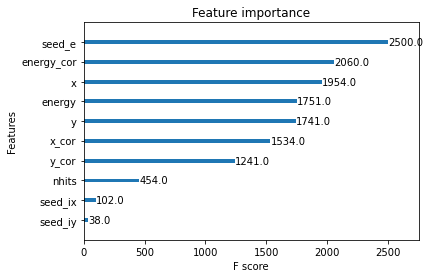

In [16]:
xgb.plot_importance(booster,grid=False); #use either the cor or the uncor values, but probably not both 

In [17]:
#this is the result using xgboost and way more muons than electrons in only single cluster events.
#should investigate way more electrons than muons, and also using sklearn

In [18]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
X=only_ecal_tr_df[0:100]
test=only_ecal_val_df[0:100]
X.shape
Y=np.array(range(0,100))
Y.shape
clf = clf.fit(X,Y)
clf.predict(test)
#this is nonsense 


array([97, 48, 63, 97, 10, 68, 45, 23, 77, 46, 44, 21, 43, 55, 39, 58, 30,
       15, 55, 99, 99, 87, 99, 86, 11, 22, 23, 91,  1, 77, 43, 14, 85, 61,
       85, 56, 43, 35, 25, 61, 18,  3, 85, 97, 25, 90, 70, 59,  8, 39, 14,
       43,  9, 12, 48, 57, 48, 51, 55, 19, 43, 81, 76, 71, 46,  6, 52, 30,
        8, 25, 21, 55, 96, 71, 57, 40, 77,  9,  7, 19, 21, 62, 78, 19, 77,
       33, 68, 91, 42, 41, 30, 65,  3, 46, 25, 12, 89, 95, 78, 93])

In [19]:

X_train = only_ecal_tr_df.drop(columns=['pdg_id']) #remove the 'truth' aka pdg_id column from the features dataset
X_test = only_ecal_val_df.drop(columns=['pdg_id']) #same thing, but for the df for testing the model
Y_train = only_ecal_tr_df['pdg_id'] #this is the df containing the truth values for the X_train features, aka which particle they are
Y_test = only_ecal_val_df['pdg_id'] #contains truth values for the test set 

#check to make sure we have the same number of entries 
X_train.shape[0]==Y_train.shape[0]
#we do the fitting here
clf.fit(X_train, Y_train)
#test the model 
clf.predict(X_test)
print("Training set score (should be very close to 1): %f" % clf.score(X_train, Y_train))
print("Test set score (how accurate the model is at classifying mu/e-): %f" % clf.score(X_test, Y_test))
print(f"So using 50k datapoints, we on average have a {(1-clf.score(X_test,Y_test))*100} % error")
#would now try to find the smallest decision tree that still gets a similar error rate to the huge tree 

Training set score (should be very close to 1): 0.999980
Test set score (how accurate the model is at classifying mu/e-): 0.951649
So using 50k datapoints, we on average have a 4.835092348284964 % error


In [20]:
tree.plot_tree(clf)

[Text(0.6178875330052213, 0.9848484848484849, 'x[0] <= 0.793\ngini = 0.358\nsamples = 50000\nvalue = [11657, 38343]'),
 Text(0.38224733495621593, 0.9545454545454546, 'x[1] <= 0.669\ngini = 0.049\nsamples = 38559\nvalue = [968, 37591]'),
 Text(0.21898602050591043, 0.9242424242424242, 'x[1] <= 0.507\ngini = 0.026\nsamples = 36386\nvalue = [482, 35904]'),
 Text(0.11364758121484098, 0.8939393939393939, 'x[4] <= -67.224\ngini = 0.016\nsamples = 33528\nvalue = [269, 33259]'),
 Text(0.046864572234252194, 0.8636363636363636, 'x[7] <= 0.077\ngini = 0.04\nsamples = 7987\nvalue = [165, 7822]'),
 Text(0.004399532549666598, 0.8333333333333334, 'x[0] <= 0.142\ngini = 0.324\nsamples = 64\nvalue = [13, 51]'),
 Text(0.003666277124722165, 0.803030303030303, 'x[7] <= 0.076\ngini = 0.422\nsamples = 43\nvalue = [13, 30]'),
 Text(0.002933021699777732, 0.7727272727272727, 'x[0] <= 0.105\ngini = 0.393\nsamples = 41\nvalue = [11, 30]'),
 Text(0.001466510849888866, 0.7424242424242424, 'x[7] <= 0.06\ngini = 0.49

Error in callback <function flush_figures at 0x7fed6440fa30> (for post_execute):


KeyboardInterrupt: 

In [21]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data) 
graph.render('mytree') 


KeyboardInterrupt: 

In [22]:
emu_df= pd.read_feather("emu.feather") 

In [23]:
#emu_df.dtypes
emu_df.tail()
emu_df.tail()
#filtered_emu=emu_df.filter("pdg_id=11")
emu_filtered = emu_df.loc[emu_df['pdg_id'].between(10,14)]
emu_elec = emu_filtered.loc[emu_filtered['pdg_id']==11]
emu_muons = emu_filtered.loc[emu_filtered['pdg_id']==13]

#emu_filtered.shape
#emu_elec.shape
emu_train = emu_filtered[0:3000]
emu_test = emu_filtered[3000:]
TRAIN = emu_train.drop(columns=['pdg_id'])
TEST = emu_test.drop(columns=['pdg_id'])
TRUTH_TRAIN = emu_train['pdg_id']
TRUTH_TEST = emu_test['pdg_id']
#filtered_emu.tail()
#need to filter dataframe to contain only pdg = 13, 11
#then need to make this into a emu_train and emu_test to test clf


In [24]:
clf.fit(TRAIN, TRUTH_TRAIN)
#test the model 
clf.predict(TEST)
print("Training set score (should be very close to 1): %f" % clf.score(TRAIN, TRUTH_TRAIN))
print("Test set score (how accurate the model is at classifying mu/e-): %f" % clf.score(TEST, TRUTH_TEST))
print(f"So using {emu_test.shape[0]} datapoints, we on average have a {(1-clf.score(TEST,TRUTH_TEST))*100} % error")

Training set score (should be very close to 1): 1.000000
Test set score (how accurate the model is at classifying mu/e-): 0.987034
So using 617 datapoints, we on average have a 1.296596434359809 % error


In [ ]:
#now test the previous model with this new data

In [25]:
clf.fit(X_train, Y_train)

DecisionTreeClassifier()

In [26]:
clf.predict(TEST)
print("Test set score (how accurate the model is at classifying mu/e-): %f" % clf.score(TEST, TRUTH_TEST))
print(f"So using {emu_test.shape[0]} datapoints with the old model with many more datapoints to fit, we on average have a {(1-clf.score(TEST,TRUTH_TEST))*100} % error")
#print("This is significantly less accurate because the old model was trained with many more muons than electrons, and the data set we passed it for testing contained many more electrons than muons!")

Test set score (how accurate the model is at classifying mu/e-): 0.878444
So using 617 datapoints with the old model with many more datapoints to fit, we on average have a 12.155591572123182 % error



This is significantly less accurate because the old model was trained with many more muons than electrons, and the data set we passed it for testing contained many more electrons than muons!

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(40,),
    max_iter=10,
    alpha=1e-4,
    solver="sgd",
    verbose=1,
    random_state=1,
    learning_rate_init=0.2,
)

#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    
mlp.fit(X_train, Y_train)

print("Training set score: %f" % mlp.score(X_train, Y_train))
print("Test set score: %f" % mlp.score(X_test, Y_test))

In [ ]:
el_df=df.Filter('mc_part_pdg[0] == 11') #create smaller df's for just electron and muon primary particles
mu_df=df.Filter('mc_part_pdg[0] == 13')
elEntries=el_df.Count() #won't return anything readable
muEntries=mu_df.Count()
print(elEntries.GetValue())
print(muEntries.GetValue())
data_train=df.Range(100000) #i want the training data to be the first 100k entires
data_test=df.Range(100000,0) #and the testing data to be the last ~27k entries
df.Display("mc_part_pdg")

root df to pandas df in mc2021 process_data.py file

#should create 1 dataframe with just electron files, and another with just muon files 
#split these into separate parts for training
#then append them, permute them, and split again for training and validation 


#df[mc_part_pdg] = df[mc_part_pdg]
#toNumpy

obj1 =[]
obj2 =[]
obj3 =[]
obj4 =[]

#FilledDataObject = df.Fill(obj1,{"ecal_custer_energy"})

#FilledDataObject = df.Fill(DataObject,{"ecal_custer_energy","ecal_seed_energy","ecal_cluster_nhits","ecal_hit_energy","mc_part_pdg"})

#df.Display()

#features = #I want columns beginning with ECal to be the features/dep vars, which ones should i pick for a first eploration?
#probably want cluster energy, cluster hits, seed energy, maybe x and y??? #should i be doing this with the mc values instead?

#can use the Cache() root function to create a new df with only the columns i want, could this work?

#cached_features = df.Cache(("ecal_custer_energy","ecal_seed_energy","ecal_cluster_nhits","ecal_hit_energy"))

#PID = #the goal is to train the decision tree on the training set using the features above to say whether the particle
#is an electron (pdg = 11) or a muon (pdg = 13)


In [ ]:
x = df.Display(["mc_part_pdg"])
x.Print()

#want to find the index of the mc_part_pdg that has the primary particle in it
#to do this, either look at mc stat or if z is ~0, then thats the original particle
#or if sim_status has bit 1 set


RVec<int> get_list_of_primary_mc(RVec<int> &mc_part_sim_status) {
/// Get a list of indexes to MCParticles (mc_part_*) of the primary particles, i.e. from the generator.
/// This version is based on the MC status word.
   RVec<int> out;
   for(size_t i=0; i< mc_part_sim_status.size(); ++i){
      if( uint(mc_part_sim_status[i]) & 0x01 ){
         out.push_back(int(i));
      }
   }
   return out;
}

In [ ]:
print(elEntries)
print(muEntries)


In [ ]:
#mu_df.GetColumnNames()

In [ ]:
mdst = R.MiniDst()          # Initiate the class
mdst.use_mc_particles=True  # Tell it to look for the MC Particles in the TTree
mdst.DefineBranchMap()      # Define the map of all the branches to the contents of the TTree
mdst.SetBranchAddressesOnTree(ch) # Connect the TChain (which contains the TTree) to the class.

In [ ]:
#events=list(range(0,ch.GetEntries()))
#for i in events:
#    ch.GetEntry(i)
#    if mdst.mc_part_pdg[0]==11:
#        print(mdst.mc_part_pdg[0])
        